## Titanic v1.0

 1. [Preliminaries](#preliminaries)  
   1.1 [Load libraries](#libraries)  
   1.2 [Load data](#load-data)  
   1.3 [Combine Data](#combine)  
   1.4 [Check for NaN's](#check-nan)
 2. [Feature engineering](#feature-eng)  
   2.1 [Column "Name"](#name)  
   2.2 [Column "Ticket"](#ticket)  
   2.3 [Column "Cabin"](#cabin)  
   2.5 [Variable encoding](#encoding)  
   2.6 [Before and after](#before-after)  
   2.6 [Split data](#split-data)  
 3. [Model](#model)  
   3.1 [Cross validation](#cv)  
   3.2 [Fitting](#fitting)
 4. [Submission](#submission)  
   4.1 [File preparation](#sub-file)  
   4.2 [Score](#score)  



## 1 - Preliminaries

<a id='libraries'></a>
### 1.1 - Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost as xgb
#from sklearn import cross_validation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

### 1.2 - Load data {#load-data}

In [2]:
df_train_raw = pd.read_csv('train.csv')
df_test_raw = pd.read_csv('test.csv')

print("df_train_raw shape =", df_train_raw.shape)
print("df_test_raw shape =", df_test_raw.shape)

df_train_raw shape = (891, 12)
df_test_raw shape = (418, 11)


<a id='combine'></a> 
### 1.3 - Combine data 

In [3]:
# Save the survived column as y for later and drop it from the train data
y_train = df_train_raw.Survived
x_train_raw = df_train_raw.drop(['Survived'], axis = 1)

# Join the X data from the train and test files, for feature processing
X_all = pd.concat((x_train_raw, df_test_raw), axis = 0, ignore_index=True)

# Save a copy of X_all for later comparison
X_all_original = X_all

print('data shape = ', X_all.shape)
X_all.head()

data shape =  (1309, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a id='check-nan'></a> 
### 1.4 - Check for NaN's

In [4]:
X_all.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

<a id='feature-eng'></a> 
## 2 - Feature engineering
<a id='name'></a> 
### 2.1 - Column "Name"

In [5]:
# Analysis and preparation of column "Name":

names = X_all.Name

print("There are " + str(pd.isnull(names).sum()) + " nan's in the name column")

There are 0 nan's in the name column


No missing names. The next step is to split each name into title, first name and surname.

In [6]:
for i in range(len(names)):
    
    full_name = str(names[i])
    
    # First split: separate the surname from the rest of the name
    name_split_1 = full_name.split(sep = ', ', maxsplit=1)
    surname = name_split_1[0]
    title_and_name = name_split_1[1]
    
    # Second split: separate the title from the rest of the name
    name_split_2 = title_and_name.split(sep = '. ', maxsplit=1)
    
    title = name_split_2[0]
    first_name = name_split_2[1]
    
    
    if(i==0):
        titles = np.array(title).reshape(1,1)
        first_names = np.array(first_name).reshape(1,1)
        surnames = np.array(surname).reshape(1,1)
        
    else:
        titles = np.append(titles, np.array(title).reshape(1,1), axis = 0)
        first_names = np.append(first_names, np.array(first_name).reshape(1,1), axis = 0)
        surnames = np.append(surnames, np.array(surname).reshape(1,1), axis = 0)
        
print("There are ", np.unique(titles).shape[0], " unique titles: ")
print(str(np.unique(titles)))

# add the title, first and last name to X_all
X_all['Title'] = titles
X_all['FirstName'] = first_names
X_all['Surname'] = surnames

X_all.head()

There are  18  unique titles: 
['Capt' 'Col' 'Don' 'Dona' 'Dr' 'Jonkheer' 'Lady' 'Major' 'Master' 'Miss'
 'Mlle' 'Mme' 'Mr' 'Mrs' 'Ms' 'Rev' 'Sir' 'the Countess']


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FirstName,Surname
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Owen Harris,Braund
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,John Bradley (Florence Briggs Thayer),Cumings
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Laina,Heikkinen
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Jacques Heath (Lily May Peel),Futrelle
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,William Henry,Allen


Having 18 unique titles could cause trouble for the model if some of them are very infrequent.

Let's analyse of the frequency of the titles and respective survival in the training data

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1464: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


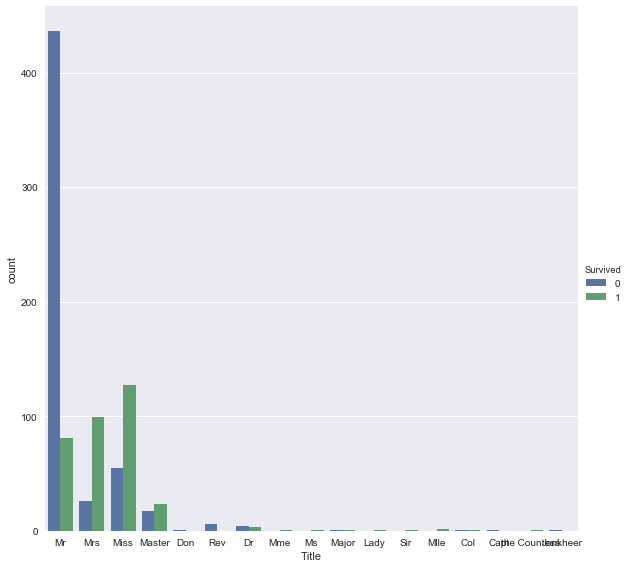

In [7]:
title_df = X_all[0:891]
title_df['Survived'] = y_train
title_df.head()

#plt.figure(figsize=(10,5))
sns.factorplot('Title',data=title_df,hue='Survived',kind='count', size = 8)


In [8]:
# to make the job easier for the model, some titles will be grouped together with the most frequent ones

X_all['Title'] = X_all['Title'].map({'Don': 'Mr',
                                     'Rev': 'Mr', 
                                     'Jonkheer': 'Mr', 
                                     'Capt': 'Mr', 
                                     'Mme': 'Mrs', 
                                     'Ms': 'Mrs', 
                                     'Lady': 'Miss', 
                                     'Sir': 'Mr', 
                                     'Mlle': 'Mrs', 
                                     'Mr': 'Mr',
                                     'Mrs': 'Mrs',
                                     'Miss': 'Miss',
                                     'Master': 'Master',
                                     'Dr': 'Dr',
                                     'Major': 'Major',
                                     'Col': 'Col',
                                     'the Countess': 'Mrs',
                                     'Dona': 'Mrs',
                                    })

In [9]:
X_all.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FirstName,Surname
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Owen Harris,Braund
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,John Bradley (Florence Briggs Thayer),Cumings
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Laina,Heikkinen
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Jacques Heath (Lily May Peel),Futrelle
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,William Henry,Allen


In [10]:
# Analysis and preparation of column "Age":
# Passenger's age

age = X_all.Age
print("There are " + str(pd.isnull(age).sum()) + " nan's in the age column")

#age = age.reshape(age.shape[0],1)

There are 263 nan's in the age column


There are a lot of nan's in the age column and this could be a problem. These nan's will be replaced by -4 and where a value is available for the age, it will be separated in ranges.

In [11]:
# The nan's will be replaced with -4
age_ = np.zeros_like(age, dtype='float64')

for i in range(len(age)):
    #print(age[i])
    if (pd.isnull(age[i])):
        age_[i] = np.float64(-4.0)
    else:
        age_[i] = np.float64(age[i])

# Split the ages into 10 bins
bins = np.array([-10.0, 0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]) 

age_ = age_.reshape(age_.shape[0],)
age_bins = np.digitize(age_, bins)

# Convert to one hot
#age_bins = age_bins.reshape(age_bins.shape[0],)
#age_bins_onehot = pd.get_dummies(age_bins)
#age_bins_onehot = age_bins_onehot.values

# Put the age column back into the dataset
X_all.Age = age_bins

<a id='ticket'></a> 
### 2.2 - Column "Ticket"

In [12]:
tickets = X_all.Ticket

print("There are " + str(pd.isnull(tickets).sum()) + " nan's in the ticket column")

There are 0 nan's in the ticket column


No missing values in the ticket column. 
The values will be split into prefix (where available) and number.

In [13]:
for i in range(len(tickets)):
    
    # get entry i of column 'ticket'
    full_ticket = str(tickets[i])
    
    # Separate the prefix from the ticket number
    ticket_split_1 = full_ticket.split(sep = ' ', maxsplit=1)
    
    # if there's no prefix, use -999
    if(len(ticket_split_1) == 1):
        # if there's no prefix, fill with 'nan' so it matches with the dtype of the elemenst in the column (str)
        prefix = 'nan'
        number = ticket_split_1[0]
    else:
        prefix = ticket_split_1[0]
        number = ticket_split_1[1]
    
    # append both strings to the respective arrays
    if(i==0):
        ticket_prefix = np.array(prefix).reshape(1,1)
        ticket_number = np.array(number).reshape(1,1)
    else:
        ticket_prefix = np.append(ticket_prefix, np.array(prefix).reshape(1,1), axis = 0)
        ticket_number = np.append(ticket_number, np.array(number).reshape(1,1), axis = 0)

# add the ticket prefix and number to X_all
X_all['TicketPrefix'] = ticket_prefix
X_all['TicketNumber'] = ticket_number

<a id='cabin'></a> 
### 2.3 - Column "Cabin"

In [14]:
#Analisys of the 'cabin' column

cabins = X_all.Cabin
print("There are " + str(pd.isnull(cabins).sum()) + " nan's in the Cabin column")

There are 1014 nan's in the Cabin column


In [15]:
for i in range(len(cabins)):
    
    # get entry from column 'cabin'
    full_cabin = str(cabins[i])
    
    #print(full_cabin)
    
    # First, check if the entry i is NaN
    if(full_cabin == 'nan'):
    # no cabin
        reserve = 0
        multiple = 0
        letter = 'Z'
    else:
        # passenger has a cabin
        reserve = 1
        
        # check if there is more than one cabin reserved
        cabin_split_1 = full_cabin.split(sep = ' ', maxsplit=1)
        
        if(len(cabin_split_1) > 1):
            multiple = 1
        else:
            multiple = 0
        
        # check the letter, corresponding to the level in the ship
        
        #cabin_split_2 = full_cabin.split(sep = '', maxsplit=1)
        letter = full_cabin[0]
        
    #print(full_cabin, ' || reserve = ', reserve, 'multiple = ', multiple, 'letter = ', letter)
    #print(cabin_split_1)
    #print('======')
    
    # append both strings to the respective arrays
    if(i==0):
        cabin_reserve = np.array(reserve).reshape(1,1)
        cabin_multiple = np.array(multiple).reshape(1,1)
        cabin_letter = np.array(letter).reshape(1,1)
    else:
        cabin_reserve = np.append(cabin_reserve, np.array(reserve).reshape(1,1), axis = 0)
        cabin_multiple = np.append(cabin_multiple, np.array(multiple).reshape(1,1), axis = 0)
        cabin_letter = np.append(cabin_letter, np.array(letter).reshape(1,1), axis = 0)

# add the ticket prefix and number to X_all
X_all['CabinReserve'] = cabin_reserve
X_all['CabinMultiple'] = cabin_multiple
X_all['CabinLetter'] = cabin_letter

<a id='encoding'></a> 
### 2.2 - Variable encoding

In [16]:
# Save a copy of X_all before encoding
X_all_before_encoding = X_all

# Convert categorical features into ordinal numbers.


def convert_to_int(column):
    # convert -column- to integer
    
    # replace nan's with -999
    column[pd.isnull(column)]  = 'NaN'
    
    # encode the column to integers
    le = LabelEncoder()
    le.fit(column.unique())
    column_int = le.transform(column)
    return column_int

In [17]:
# Name, Ticket might not be very useful, consider removing later
X_all.Sex = convert_to_int(X_all.Sex)
X_all.Embarked = convert_to_int(X_all.Embarked)
X_all.Title = convert_to_int(X_all.Title)
X_all.Surname = convert_to_int(X_all.Surname)
X_all.TicketPrefix = convert_to_int(X_all.TicketPrefix)
X_all.CabinLetter = convert_to_int(X_all.CabinLetter)

#X_all.Name = convert_to_int(X_all.Name)
#X_all.Name = convert_to_int(X_all.Name)

# Drop Name, Ticket, Cabin, FirstName, TicketNumber
X_all = X_all.drop(['Name'], axis = 1)
X_all = X_all.drop(['Ticket'], axis = 1)
X_all = X_all.drop(['Cabin'], axis = 1)
X_all = X_all.drop(['FirstName'], axis = 1)
X_all = X_all.drop(['TicketNumber'], axis = 1)

#X_all = X_all.drop(['PassengerId'], axis = 1)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<a id='before-after'></a> 
### 2.2 - Before and after

The original data, before being processed:

In [18]:
X_all_original.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FirstName,Surname,TicketPrefix,TicketNumber,CabinReserve,CabinMultiple,CabinLetter
0,1,3,"Braund, Mr. Owen Harris",1,4,1,0,A/5 21171,7.2500,NaN,3,5,Owen Harris,100,5,21171,0,0,8
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,5,1,0,PC 17599,71.2833,C85,0,6,John Bradley (Florence Briggs Thayer),182,21,17599,1,0,2
2,3,3,"Heikkinen, Miss. Laina",0,4,0,0,STON/O2. 3101282,7.9250,NaN,3,4,Laina,329,42,3101282,0,0,8
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,5,1,0,113803,53.1000,C123,3,6,Jacques Heath (Lily May Peel),267,49,113803,1,0,2
4,5,3,"Allen, Mr. William Henry",1,5,0,0,373450,8.0500,NaN,3,5,William Henry,15,49,373450,0,0,8


After preprocessing, before variable encoding:

In [19]:
X_all_before_encoding.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FirstName,Surname,TicketPrefix,TicketNumber,CabinReserve,CabinMultiple,CabinLetter
0,1,3,"Braund, Mr. Owen Harris",1,4,1,0,A/5 21171,7.2500,NaN,3,5,Owen Harris,100,5,21171,0,0,8
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,5,1,0,PC 17599,71.2833,C85,0,6,John Bradley (Florence Briggs Thayer),182,21,17599,1,0,2
2,3,3,"Heikkinen, Miss. Laina",0,4,0,0,STON/O2. 3101282,7.9250,NaN,3,4,Laina,329,42,3101282,0,0,8
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,5,1,0,113803,53.1000,C123,3,6,Jacques Heath (Lily May Peel),267,49,113803,1,0,2
4,5,3,"Allen, Mr. William Henry",1,5,0,0,373450,8.0500,NaN,3,5,William Henry,15,49,373450,0,0,8


After variable encoding and dropping some of the columns:

In [20]:
X_all.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Surname,TicketPrefix,CabinReserve,CabinMultiple,CabinLetter
0,1,3,1,4,1,0,7.2500,3,5,100,5,0,0,8
1,2,1,0,5,1,0,71.2833,0,6,182,21,1,0,2
2,3,3,0,4,0,0,7.9250,3,4,329,42,0,0,8
3,4,1,0,5,1,0,53.1000,3,6,267,49,1,0,2
4,5,3,1,5,0,0,8.0500,3,5,15,49,0,0,8


<a id='split-data'></a> 
### 2.2 - Split data

In [21]:
X_train = X_all[0:891]
X_submission = X_all[891:]

<a id='model'></a> 
## 3 - Model

<a id='cv'></a>
### 3.1 - Cross Validation

In [22]:
regr = xgb.XGBClassifier()

tuned_parameters = [{'eval_metric': ['logloss'],
                     'objective': ["binary:logistic"],
                     'max_depth': [8, 9, 10, 11], 
                     'n_estimators': [1000], 
                     'eta': [0.1, 0.2, 0.3],
                     'reg_lambda': [0.5, 1.5, 2.5],
                     'nthread': [4],
                     'subsample': [1],
                     'colsample_bytree': [0.3, 0.5, 0.7],
                     'alpha': [0.5, 1.5, .5],
                     'min_child_weight': [2, 4, 6, 8]}]
n_folds = 5

In [23]:
regr_grid = GridSearchCV(regr, tuned_parameters, cv=n_folds, refit=False, verbose = 1)
#regr_grid.fit(X_train, y_train)

In [24]:
print("Best parameters set found on development set:")
print(regr_grid.best_params_)
print("Best score:")
print(regr_grid.best_score_ )

Best parameters set found on development set:


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [25]:
print("Grid scores on development set:")
print()
means = regr_grid.cv_results_['mean_test_score']
stds = regr_grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, regr_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:



AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

<a id='fitting'></a>
### 3.2 - Fitting

In [33]:
# fit using the optimal settings

regr_optimum = xgb.XGBClassifier(eval_metric = 'logloss', 
                         objective =  "binary:logistic",
                         max_depth = 9,
                         n_estimators = 1000,
                         eta = 0.1,
                         nthread = 4,
                         subsample= 1,
                         colsample_bytree= 0.3,
                         reg_lambda= 2.5,
                         alpha= 0.5,
                         min_child_weight= 8
                         )

regr_optimum.fit(X_train, y_train)

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=0.3, eta=0.1,
       eval_metric='logloss', gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=8, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=2.5, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

<a id='submission'></a>
## 4 - Submission

<a id='sub-file'></a>
### 4.1 - File preparation

In [34]:
y_pred_subm = regr_optimum.predict(X_submission)

submission_PassengerId = pd.DataFrame(df_test_raw.PassengerId)
submission_Survived = pd.DataFrame(y_pred_subm)

submission = pd.concat((submission_PassengerId, submission_Survived), axis = 1)
submission.columns = ['PassengerId', 'Survived']
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [35]:
submission.to_csv('submission.csv', index = False)

<a id='score'></a>
### 4.2 - Score

![Logistic Regression score](https://raw.githubusercontent.com/jgamboias/Titanic/master/logreg_submission.png)